# Reducing ill conditioned Markov Chains with Graph Transformation (GT)

This cell loads our `PyGT` package, `tqdm` for progress bars, and defines some helper functions

In [52]:
!pip install PyGT tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spla
import os.path as Path
from PyGT.io import load_ktn
from PyGT.GT import blockGT
from PyGT.mfpt import full_MFPT_matrix
from PyGT.stats import compute_passage_stats as fpt
from scipy.sparse.linalg import eigs,inv,spsolve

from scipy.sparse import diags,eye,issparse
from tqdm.notebook import tqdm

def ev(Q):
    nu = spla.eigvals(Q)
    return np.sort(-nu.real)

def select_states_to_remove(B_matrix,participation):
    N_states = B_matrix.shape[0]
    denseB = np.zeros(B.shape)
    B.todense(out=denseB)

    connections = denseB>0

    rm_vec = np.ones(N_states,bool)

    for i in range(N):
        # boundary nodes
        if not (participation[connections[i]]==participation[i]).min():
            rm_vec[i] = False

        # local minima
        if (u)[participation == participation[i]].min()==(u)[i]:
            rm_vec[i] = False
    print(f"""
        Retained Nodes: {N_states-rm_vec.sum()}
    """)
    return rm_vec

def condition_number_estimation(Q):
    if issparse(Q):
        MQ = Q.todense().copy()
    else:
        MQ = Q.copy()
    MQ -= np.diag(np.diag(MQ))
    return np.linalg.cond(MQ)

def es_compute_passage_stats(A_sel, B_sel, pi, K, dopdf=True,rt=None):
    r"""Compute the A->B and B->A first passage time distribution,
    first moment, and second moment using eigendecomposition of a CTMC
    rate matrix.

    Parameters
    ----------
    A_sel : (N,) array-like
        boolean array that selects out the A nodes
    B_sel : (N,) array-like
        boolean array that selects out the B nodes
    pi : (N,) array-like
        stationary distribution
    K : (N, N) array-like
        CTMC rate matrix

    dopdf : bool, optional
        Do we calculate full fpt distribution or just the moments. Defaults=True.
    rt: array, optional
        Vector of times to evaluate first passage time distribution in multiples
        of :math:`\left<t\right>` for A->B and B->A. If ``None``, defaults to a logscale
        array from :math:`0.001\left<t\right>` to :math:`1000\left<t\right>`
        in 400 steps, i.e. ``np.logspace(-3,3,400)``.
        Only relevant if ``dopdf=True``

    Returns
    -------
    tau : (4,) array-like
        First and second moments of first passage time distribution for A->B and B->A [:math:`\mathcal{T}_{\mathcal{B}\mathcal{A}}`, :math:`\mathcal{V}_{\mathcal{B}\mathcal{A}}`, :math:`\mathcal{T}_{\mathcal{A}\mathcal{B}}`, :math:`\mathcal{V}_{\mathcal{A}\mathcal{B}}`]
    pt : ( len(rt),4) array-like
        time and first passage time distribution p(t) for A->B and B->A

    """
    #multiply by negative 1 so eigenvalues are positive instead of negative
    Q=-K
    if rt is None:
        rt = np.logspace(-3,3,400)
    #<tauBA>, <tau^2BA>, <tauAB>, <tau^2AB>
    tau = np.zeros(4)
    if dopdf:
        # time*tau_range, p(t) (first 2: A->B, second 2: B->A)
        pt = np.zeros((4,len(rt)))

    #A -> B
    #P(0) is initialized to local boltzman of source community A
    rho = pi * A_sel
    rho /= rho.sum()
    #B is absorbing, so we want Q in space of A U I
    M = Q[~B_sel,:][:,~B_sel]
    x = spsolve(M,rho[~B_sel])
    y = spsolve(M,x)
    # first moment tau(A->B) = 1.Q^{-1}.rho(A) = 1.x
    tau[0] = x.sum()
    # second moment = 2 x 1.Q^{-2}.rho = 2.0* 1.Q^{-1}.x
    tau[1] = 2.0*y.sum()
    if dopdf:
        #time in multiples of the mean first passage time
        pt[0] = rt*tau[0]
        #nu=eigenvalues, v=left eigenvectors, w=right eigenvectors
        nu,v,w = spla.eig(M.todense(),left=True)
        #print(nu[0])
        #sort eigenvalues
        nu_sorted = sorted(nu)
        tau_m = 1/(nu_sorted[1]-nu_sorted[0])
        print("tau_m/TAU_AB " + str(tau_m/tau[0]))
        #print("mixing time " + str(tau_m))
        #print("lambda0*tau_m " + str(nu_sorted[0]*tau_m))
        #normalization factor
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        #dot product (v.P(0)=rho)
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~B_sel])
        #dot product (1.T.w)
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        #(v*w/nu).sum() is the same as <tau>, the first bit is the pdf p(t)
        pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))#*(v*w/nu).sum()

    #B -> A
    rho = pi * B_sel
    rho /= rho.sum()
    M = Q[~A_sel,:][:,~A_sel]
    x = spsolve(M,rho[~A_sel])
    y = spsolve(M,x)
    tau[2] = x.sum()
    tau[3] = 2.0*y.sum()
    if dopdf:
        pt[2] = rt*tau[2]
        nu,v,w = spla.eig(M.todense(),left=True)
        #sort eigenvalues
        nu_sorted = sorted(nu)
        tau_m = 1/(nu_sorted[1]-nu_sorted[0])
        print("tau_m/TAU_AB " + str(tau_m/tau[2]))
        #print("mixing time " + str(tau_m))
        #print("lambda0*tau_m " + str(nu_sorted[0]*tau_m))
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~A_sel])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))#*(v*w/nu).sum()
        return tau, pt.T
    else:
        return tau




DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


## Load 9-macrostate model and BACE-defined community participation

In [53]:
data_path = 'example-data-9-communities/'

T = 1e0

B, K, tau, N, u, s, Emin, retained = \
  load_ktn(path=data_path,beta=1.0/T,screen=True)

Q = K-diags(1.0/tau)

full_cond = condition_number_estimation(B)
print(f"""
    Estimated condition number of B: {full_cond}
    """)

pi = np.exp(-u/T+s)
print("pi " + str(pi))
pi /= pi.sum()



communities = \
  np.loadtxt(Path.join(data_path,'communities_bace9.dat')).astype(int)


for ic in zip(*np.unique(communities,return_counts=True)):
    print("\tCommunity",ic[0]+1,":",ic[1],"states")



	Connected Clusters: 1, of which 95% have <= 994 states
	Retaining largest cluster with 994 nodes


    Estimated condition number of B: 42482582649.66834
    
pi [1.31960497e-10 4.52424940e-02 3.46621161e-08 1.25075496e-09 2.51435805e-11 1.29581908e-16 4.99947262e-10 1.21100106e-09 3.66025358e-10 1.81197520e-11
 6.72258533e-14 1.73219930e-04 2.13066017e-04 3.03180422e-15 4.00911968e-02 7.85081637e-11 2.52170836e-01 1.21095788e-02 8.46709698e-13 1.25930785e-08
 3.65423843e-13 1.69888610e-14 9.64575115e-11 1.95403525e-01 7.70140374e-12 5.94727083e-10 2.41555260e-17 4.54488587e-12 3.75158025e-07 8.13046017e-11
 3.86042450e-07 2.88893438e-13 2.76009964e-03 2.42157347e-11 4.50049643e-13 2.75125392e-03 2.03825094e-06 1.39033863e-09 8.74067754e-13 9.16418192e-12
 2.24843053e-10 2.71341222e-05 8.04279895e-07 4.21806778e-07 4.97831788e-06 1.55871575e-08 8.40613876e-08 3.60886045e-06 1.75102725e-12 1.24067625e-01
 1.06624949e-09 2.19044992e-05 1.04316347e-15 7.27939196e-09 1.30374773e-16 9.491

## Find boundary nodes and community minima, then perform GT reduction

(2, 215)

In [54]:
# boolean vector of states to remove
rm_vec = select_states_to_remove(B,communities)

retained_states = ~rm_vec.copy()
#print(retained_states)

# block GT reduction
r_B, r_tau, r_Q = blockGT(rm_vec,B,tau,block=50,rates=True,screen=True)

r_Q_d = r_Q.toarray()
print("r_Q_d " + str(r_Q_d))
print("shape " + str(r_Q_d.shape))
#if issparse(r_Q):
    #r_Q_d = r_Q.todense().copy()

    
#print(r_Q_d.shape)
#print("r_Q_d " + str(r_Q_d))
#print("r_Q_d[0][0] " +  str(r_Q_d[0]))
#print(r_Q_d[0].shape)
#print("rQ_d " + str(r_Q_d))
#print("################################")

#r_tau: array of renormalised waiting times
#tau: array of full network waiting times
r_pi = pi[retained_states] * r_tau / tau[retained_states]
#Normalising r_pi
r_pi = r_pi/r_pi.sum()

#Saving the stationary distribution for reduced network to file
np.savetxt(Path.join(data_path, 'esmae_reduced_stat_prob.dat'), np.log(r_pi),fmt="%.16f")
#Saving the stationary distribution for full network to file
np.savetxt(Path.join(data_path, 'esmae_full_stat_prob.dat'), np.log(pi),fmt="%.16f")


r_ids = np.arange(communities.size)[retained_states] 
r_communities = communities[retained_states]

#Producing community files for reduced network
#Open all comms files
COMM_PATTERN = data_path + "esmae_reduced_comms"
FULL_COMM_PATTERN = data_path + "esmae_full_comms"
all_comms = np.arange(9)
cfiles = []
fcfiles = []
for ci in range(len(all_comms)):
        cfilename=COMM_PATTERN+str(all_comms[ci])+".dat"
        fcfilename=FULL_COMM_PATTERN+str(all_comms[ci])+".dat"
        print(cfilename)
        cfile = open(cfilename,"w")
        cfiles.append(cfile)
        fcfile = open(fcfilename, "w")
        fcfiles.append(fcfile)
        
#communities are labelled 0...8
for i in range(len(r_communities)):
    c = r_communities[i]
    node = i+1
    cfiles[c].writelines(str(node) + '\n')
for i in range(len(communities)):
    c = communities[i]
    node = i+1
    fcfiles[c].writelines(str(node)+'\n')
    
for file in cfiles:
    file.close()
for file in fcfiles:
    file.close()
    
#np.savetxt(Path.join,'esmae_reduced_comms' + str(i) + '.dat'), np.stack(

# save files
np.savetxt(Path.join(data_path,'esmae_reduced_communities_bace9.dat'),
           np.stack((r_ids + 1,r_communities)).T,fmt="%d %d",header="NB: nodes are indexed from one, communities are 0-indexed !")
np.savetxt(Path.join(data_path,'esmae_reduced_bace9.dat'),
           r_ids + 1, fmt="%d")
#save edge_conns.dat and edge_weights.dat files for discotress

connA = []
connB = []
r1 = []
r2 = []

        
for i in range(retained_states.sum()):
    for j in range(retained_states.sum()):
        if r_Q_d[i][j]:
            if i<j: 
                connA.append(i+1)
                connB.append(j+1)
                r1.append(np.log(r_Q_d[i][j]))
                r2.append(np.log(r_Q_d[j][i]))
                
                #print("i:" + str(i) + " j:" + str(j) + " " + str(r_Q_d[i][j]))
                
np.savetxt(Path.join(data_path, 'esmae_reduced_edge_conns.dat'), np.stack((connA, connB)).T,fmt="%d %d")
#print('{:<10s}{:>4s}{:>12s}{:>12s}'.format(data[i][0],data[i][1],data[i][2],data[i][3]))
np.savetxt(Path.join(data_path, 'esmae_reduced_edge_weights.dat'), np.stack((r2, r1)).T, fmt="%.16f %.16f", delimiter=' ')

r_full_cond = condition_number_estimation(r_B)
print(f"""
    Estimated condition number of    B: {full_cond:.2f}
    Estimated condition number of GT_B: {r_full_cond:.2f} 
""")


        Retained Nodes: 215
    


GT:   0%|          | 0/779 [00:00<?, ?it/s]

GT removed 779 nodes in 0.1 seconds with 0 floating point corrections
r_Q_d [[-7.76081121e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.51023667e-02  0.00000000e+00 ...  0.00000000e+00  1.41344569e-19  4.68473675e-18]
 [ 0.00000000e+00  0.00000000e+00 -2.63974767e-05 ...  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.26743430e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03192201e-19  0.00000000e+00 ...  0.00000000e+00 -1.48846673e-02  2.43536411e-03]
 [ 0.00000000e+00  1.36955371e-18  0.00000000e+00 ...  0.00000000e+00  4.95256142e-04 -2.33995334e-02]]
shape (215, 215)
example-data-9-communities/esmae_reduced_comms0.dat
example-data-9-communities/esmae_reduced_comms1.dat
example-data-9-communities/esmae_reduced_comms2.dat
example-data-9-communities/esmae_reduced_comms3.dat
example-data-9-communities/esmae_reduced_comms4.dat
example-data-9-communit

## First passage time distributions


  0%|          | 0/6 [00:00<?, ?it/s]

communities [6 6 5 4 2 2 3 6 5 3 6 1 6 6 1 1 6 0 3 0 7 1 4 5 3 4 6 4 5 3 1 0 1 0 5 4 5 2 6 6 6 4 1 4 1 1 2 2 1 2 6 0 1 4 6 7 2 4 0 5 4 8 7 5 4 5 0 0 1 6 2 3 1 4 2 6 3 7 1
 8 7 7 3 6 0 3 3 3 2 1 8 8 5 0 2 5 6 7 6 1 2 3 1 6 5 6 2 5 4 3 1 3 0 6 7 0 6 5 3 1 2 1 8 2 0 8 5 3 6 5 4 5 4 3 5 3 2 2 5 6 3 3 6 4 6 7 6 6 3 6 7 5 5 2 1 0 1 2
 7 7 5 4 8 2 7 4 7 1 7 6 1 2 1 7 5 7 4 7 1 6 6 8 1 3 1 1 3 0 4 1 7 7 6 6 6 6 5 1 6 5 1 2 7 6 1 6 4 0 5 6 4 6 0 2 1 6 1 2 6 3 4 0 6 3 7 2 0 7 6 3 2 4 1 0 3 4 0
 6 6 3 0 0 0 4 7 0 4 3 7 0 7 5 6 6 4 5 1 1 3 3 6 6 7 5 5 5 4 4 1 8 3 1 5 4 7 7 3 3 6 0 0 0 1 3 7 6 4 1 2 6 2 6 8 7 7 6 5 3 7 4 4 6 2 6 2 3 6 4 3 4 0 6 8 5 4 2
 2 5 2 2 3 3 7 3 6 1 3 8 4 1 7 3 0 3 6 0 6 7 8 5 4 1 7 7 4 7 6 1 7 4 4 6 5 4 0 6 3 8 4 3 6 4 7 1 0 5 7 8 5 4 3 3 3 3 5 1 6 4 7 8 1 3 5 6 6 2 6 0 3 1 4 7 6 3 0
 6 8 5 4 4 3 0 3 0 6 6 3 6 2 1 6 5 3 6 6 4 5 1 3 1 1 4 4 7 0 6 4 5 8 2 7 1 2 7 1 2 1 1 6 0 3 6 1 6 2 1 3 1 3 8 6 6 7 4 1 2 4 4 0 3 7 0 4 7 6 2 0 6 0 2 4 1 6 1
 6 6 1 4 3 6 2 3 6 5 6 7 3 4 8 4 0

reduced network
communities [6 6 5 4 2 2 3 6 5 3 6 1 6 6 1 1 6 0 3 0 7 1 4 5 3 4 6 4 5 3 1 0 1 0 5 4 5 2 6 6 6 4 1 4 1 1 2 2 1 2 6 0 1 4 6 7 2 4 0 5 4 8 7 5 4 5 0 0 1 6 2 3 1 4 2 6 3 7 1
 8 7 7 3 6 0 3 3 3 2 1 8 8 5 0 2 5 6 7 6 1 2 3 1 6 5 6 2 5 4 3 1 3 0 6 7 0 6 5 3 1 2 1 8 2 0 8 5 3 6 5 4 5 4 3 5 3 2 2 5 6 3 3 6 4 6 7 6 6 3 6 7 5 5 2 1 0 1 2
 7 7 5 4 8 2 7 4 7 1 7 6 1 2 1 7 5 7 4 7 1 6 6 8 1 3 1 1 3 0 4 1 7 7 6 6 6 6 5 1 6 5 1 2 7 6 1 6 4 0 5 6 4 6 0 2 1 6 1 2 6 3 4 0 6 3 7 2 0 7 6 3 2 4 1 0 3 4 0
 6 6 3 0 0 0 4 7 0 4 3 7 0 7 5 6 6 4 5 1 1 3 3 6 6 7 5 5 5 4 4 1 8 3 1 5 4 7 7 3 3 6 0 0 0 1 3 7 6 4 1 2 6 2 6 8 7 7 6 5 3 7 4 4 6 2 6 2 3 6 4 3 4 0 6 8 5 4 2
 2 5 2 2 3 3 7 3 6 1 3 8 4 1 7 3 0 3 6 0 6 7 8 5 4 1 7 7 4 7 6 1 7 4 4 6 5 4 0 6 3 8 4 3 6 4 7 1 0 5 7 8 5 4 3 3 3 3 5 1 6 4 7 8 1 3 5 6 6 2 6 0 3 1 4 7 6 3 0
 6 8 5 4 4 3 0 3 0 6 6 3 6 2 1 6 5 3 6 6 4 5 1 3 1 1 4 4 7 0 6 4 5 8 2 7 1 2 7 1 2 1 1 6 0 3 6 1 6 2 1 3 1 3 8 6 6 7 4 1 2 4 4 0 3 7 0 4 7 6 2 0 6 0 2 4 1 6 1
 6 6 1 4 3 6 2 3 6

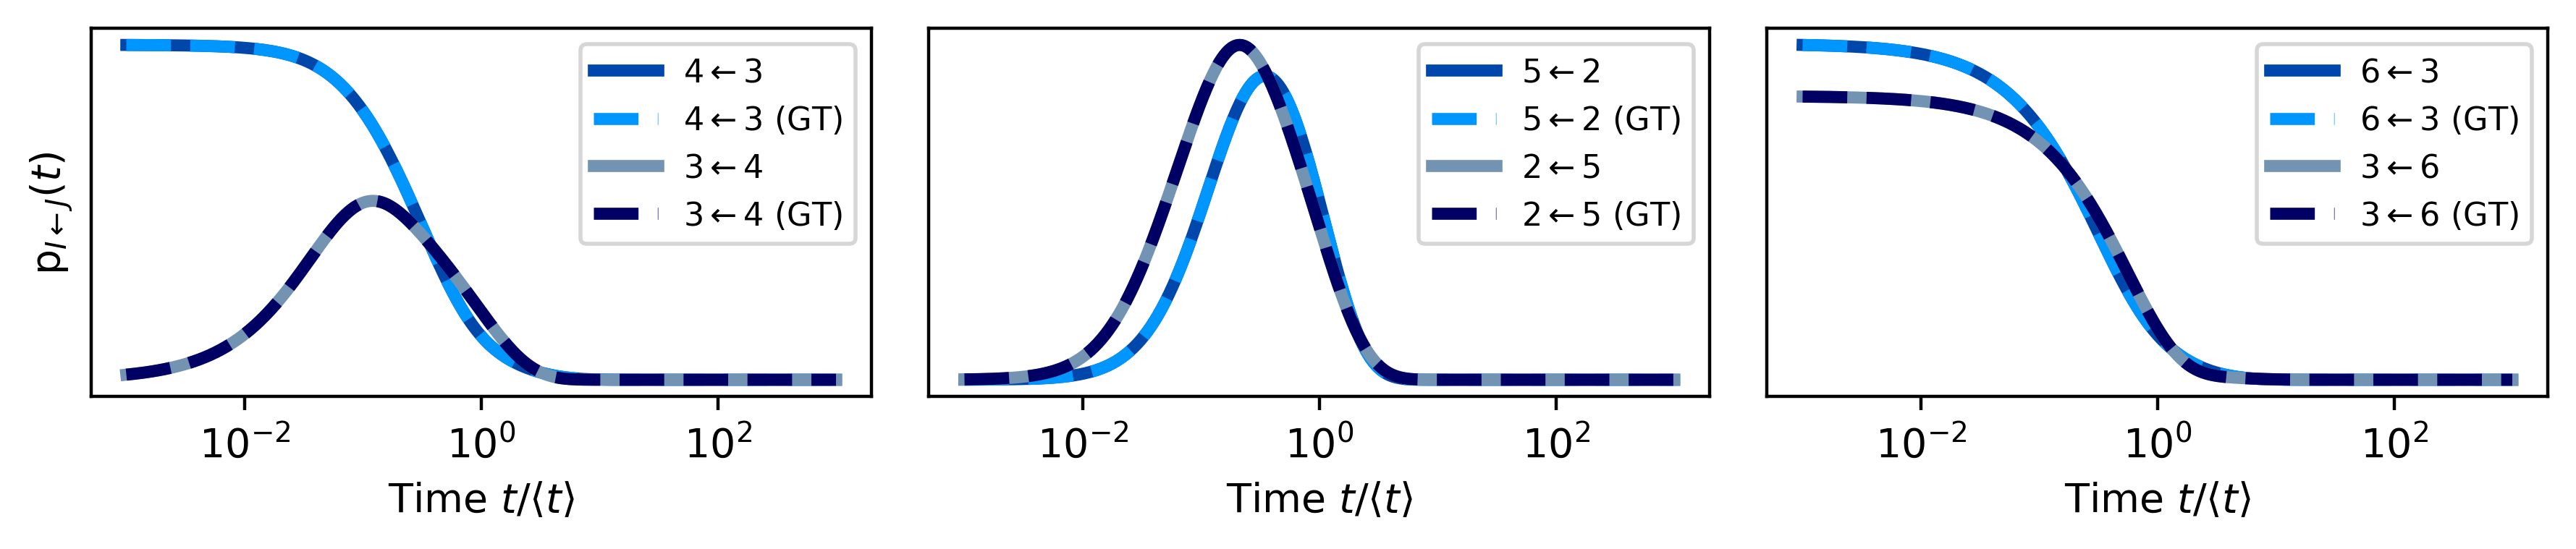

In [55]:
#Options for initial state are:
#uni: uniform for full network and reduced network across full B
#uni2: uniform for full network and reduced network on B states that are in reduced network
#stat: stationary distribution
#stat2: stationary distribution only on states that are in reduced network
#globmin: All probability on global minimum of B
init_state = "stat" 

#fig,axs = plt.subplots(2,3,figsize=(9,4),dpi=120,sharex='col')
fig, axs = plt.subplots(1,3,figsize=(9,2),dpi=400,sharex='col')
fig.patch.set_facecolor('white')
cc = 0
pbar = tqdm(total=6)
for cA in range(2,7):
    for cB in range(2,7):
        if cA>cB and ((cA==4 and cB==3) or (cA==5 and cB==2) or (cA==6 and cB==3)):
            #Communities are labelled 0...8
            print("communities " + str(communities))
            A_sel = communities==(cA-1) #Numpy array of True and Falses for each node, True if in community cA
            B_sel = communities==(cB-1)
            r_A_sel = A_sel[retained_states]
            r_B_sel = B_sel[retained_states]
            fr_A_sel = A_sel
            for i in range(0,len(fr_A_sel)):
                if not retained_states[i]:
                    fr_A_sel=False
                    
            #print("retained states " + str(retained_states))

            #Uniform distribution
            #Full network
            p_0_uni = np.zeros(pi.shape)
            p_0_uni[A_sel] = 1/A_sel.sum()
            p_0_uni[B_sel] = 1/B_sel.sum()
            #print("sum should be 2 " + str(p_0_uni.sum()))
            #reduced network
            r_p_0_uni = np.zeros(retained_states.sum())
            r_p_0_uni[r_A_sel] = 1/r_A_sel.sum()
            r_p_0_uni[r_B_sel] = 1/r_B_sel.sum()
            #print("sum should be 2 " + str(r_p_0_uni.sum()))
            #Full network uniform but only for reduced nodes
            p_0_uni2 = np.zeros(pi.shape)
            p_0_uni2[retained_states] = r_p_0_uni
            #p_0_uni2[A_sel] *= 1/r_A_sel.sum()
            #p_0_uni2[B_sel] *= 1/r_B_sel.sum()
            #p_0_uni2[!retained_states] = 0.0
            #print("p_0_uni2 " + str(p_0_uni2))
            #print("sum should be 2 " + str(p_0_uni2.sum()))
            #Stationary distribution but only for reduced nodes
            pi_2 = np.zeros(pi.shape)
            pi_2[retained_states] = r_pi
            
        
        
            # define initial distribution as in paper
            p_0 = np.zeros(pi.shape)
            p_0[A_sel] = np.arange(A_sel.sum()) == pi[A_sel].argmax() #RHS: Index of minimum of A_sel community
            p_0[B_sel] = np.arange(B_sel.sum()) == pi[B_sel].argmax()
            print("B: " + str(cB))
            print(p_0)
            index_1 = 1
            for x in p_0:
                if x==1:
                    print(index_1)
                index_1 += 1
                

            # define same quantities for GT reduced system
            r_p_0 = p_0[retained_states]
            r_A_sel = A_sel[retained_states]
            r_B_sel = B_sel[retained_states]

            # mfpt: <t_AB>, <t^2_AB>, <t_BA>, <t^2_BA>
            #print("p_0 " + str(p_0))
            
            #Setting the initial state
            if init_state=="uni":
                pi_init = p_0_uni
                r_pi_init = r_p_0_uni
            elif init_state=="uni2":
                pi_init = p_0_uni2
                r_pi_init = r_p_0_uni
            elif init_state=="stat":
                pi_init = pi
                r_pi_init = r_pi
            elif init_state=="stat2":
                pi_init = pi_2
                r_pi_init = r_pi
            elif init_state=="globmin":
                pi_init = p_0
                r_pi_init = r_p_0
            else:
                print("Error incorrect initial state")
            print("cA:" + str(cA) + " cB:" + str(cB))
            print("full network")
            mfpt,fptd = fpt(A_sel=A_sel,B_sel=B_sel,pi=pi_init,K=Q,dopdf=True)
            #print("fptd[:,0] ")
            #print(fptd[:,0])
            #print(len(fptd[:,0]))

            print("reduced network")
            # r_mfpt: <t_AB>, <t^2_AB>, <t_BA>, <t^2_BA>
            #print("r_p_0 " + str(r_p_0))
            r_mfpt,r_fptd = \
                fpt(A_sel=r_A_sel,B_sel=r_B_sel,pi=r_pi_init,K=r_Q,dopdf=True)
            #print("CA " + str(cA))
            #print("CB " + str(cB))
            #print("r_mfpt " + str(r_mfpt))
            #Saving reduced data to file
            
            np.savetxt("data/mean" + str(cA) + str(cB) + "_" + init_state + "_" + str(T) + ".dat",np.stack((mfpt,r_mfpt)))
            i,j = cc%2,cc//2
            #print(i)
            #print(j)
            #saving data in time units, and modulating fptd accordingly, so area under curve still one
            np.savetxt("data/fptv2_py_r" + str(cA) + str(cB) + "_" + init_state + ".dat",np.stack((r_fptd[:,2],r_fptd[:,3]/r_mfpt[2])).T)
            np.savetxt("data/fptv2_py_r" + str(cB) + str(cA) + "_" + init_state + ".dat",np.stack((r_fptd[:,0],r_fptd[:,1]/r_mfpt[0])).T)
            np.savetxt("data/fptv2_py_" + str(cA) + str(cB) + "_" + init_state + ".dat",np.stack((fptd[:,2],fptd[:,3]/mfpt[2])).T)
            np.savetxt("data/fptv2_py_" + str(cB) + str(cA) + "_" + init_state + ".dat",np.stack((fptd[:,0],fptd[:,1]/mfpt[0])).T)                       
            

            np.savetxt("data/fpt_py_r" + str(cA) + str(cB) + "_" + init_state + ".dat",np.stack((r_fptd[:,3],r_fptd[:,2])).T)
            np.savetxt("data/fpt_py_r" + str(cB) + str(cA) + "_" + init_state + ".dat",np.stack((r_fptd[:,1],r_fptd[:,0])).T)
            np.savetxt("data/fpt_py_" + str(cA) + str(cB) + "_" + init_state + ".dat",np.stack((fptd[:,3],fptd[:,2])).T)
            np.savetxt("data/fpt_py_" + str(cB) + str(cA) + "_" + init_state + ".dat",np.stack((fptd[:,1],fptd[:,0])).T)                        
            #initially axs are [i,j] for 2,3 grid
            axs[cc].semilogx(fptd[:,2]/mfpt[2],fptd[:,3],lw=3,color=(0,71/255,171/255),
                            label=fr"{cA}$\leftarrow${cB}")
            axs[cc].semilogx(r_fptd[:,2]/r_mfpt[2],r_fptd[:,3],'--',lw=3,color=(0,150/255,255/255),
                            label=fr"{cA}$\leftarrow${cB} (GT)")

            axs[cc].semilogx(fptd[:,0]/mfpt[0],fptd[:,1],lw=3,color=(115/255,147/255,179/255),
                            label=fr"{cB}$\leftarrow${cA}")
            axs[cc].semilogx(r_fptd[:,0]/r_mfpt[0],r_fptd[:,1],'--',lw=3,color=(0,0,100/255),
                            label=fr"{cB}$\leftarrow${cA} (GT)")

            axs[cc].set_yticks([])
            #if i==0:
            #    axs[i,j].set_xticks([])
            #else:
            #    axs[i,j].set_xlabel(r"Time $t/\langle{t}\rangle$")
            axs[cc].set_xlabel(r"Time $t/\langle{t}\rangle$")
            if cc==0:
                axs[cc].set_ylabel(r"${\rm p}_{I\leftarrow J}(t)$")

            axs[cc].legend(fontsize=8)
            cc+=1
            pbar.update(1)
#plt.suptitle( "Selected first passage distributions for 9-community model,"
 # f" T={int(T)} Initial state={str(init_state)}",y=0.94)
#plt.suptitle(f"T={int(T)}", y=0.94)
plt.subplots_adjust(wspace=0,hspace=0)
plt.tight_layout()
plt.savefig(f"figures/pdf_comp_T{int(T)}_{init_state}_paper_3.pdf")
plt.show()